In [1]:
!docker-compose up -d
!pip3 install elasticsearch
!pip3 install tabletext
!pip3 install plotly

Starting elasticsearch ... 


In [2]:
from elasticsearch import Elasticsearch
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go


init_notebook_mode(connected=True)
es = Elasticsearch(["127.0.0.1:9200"], http_compress=True)

def process_table_data(source):
    ids = []
    scores = []
    published_at = []
    titles = []
    for doc in source:
        ids.append(doc['_id'])
        scores.append(doc['_score'])
        published_at.append(doc['_source']['published_at'])
        titles.append(doc['_source']['title'])
    # print(tabletext.to_text(data))
    trace = go.Table(
        header=dict(values=["ID","Score","Published_at","Title"]),
        cells=dict(values=[ids,scores,published_at,titles])
    )
    data = [trace]
    return data

def process_chart_data(res):
    key = []
    value = []
    
    for data in res['aggregations']['agg']['buckets']:
        key.append(data['key'])
        value.append(data['doc_count'])
    
    data = [go.Bar(
                x = key,
                y = value
            )]
    return data

238 documents found in 365ms


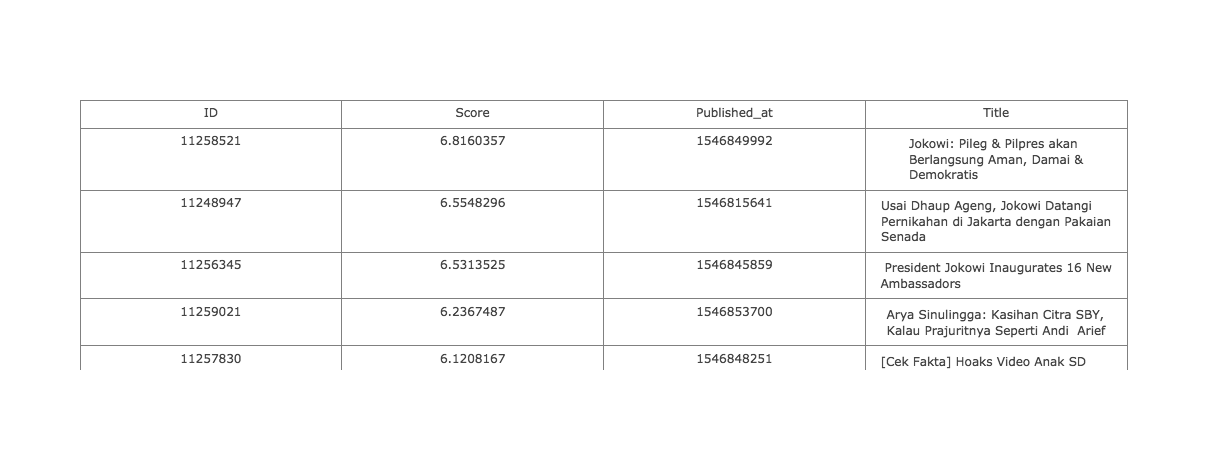

In [3]:
### MULTI MATCH SEARCH
query = '''
{
    "from": 0, 
    "size": 10,
    "query": {
        "bool": {
            "must": [
                {
                    "multi_match": {
                        "query": "joko",
                        "fields": [
                            "title",
                            "content",
                            "excerpt"
                        ]
                    }
                }
            ]
        }
    },
    "sort": [
        "_score",
        {
            "published_at": "desc"
        }
    ]
}
'''
res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=res['hits']['total'], arg2=res['took']))

iplot(process_table_data(res['hits']['hits']))

6 documents found in 112ms


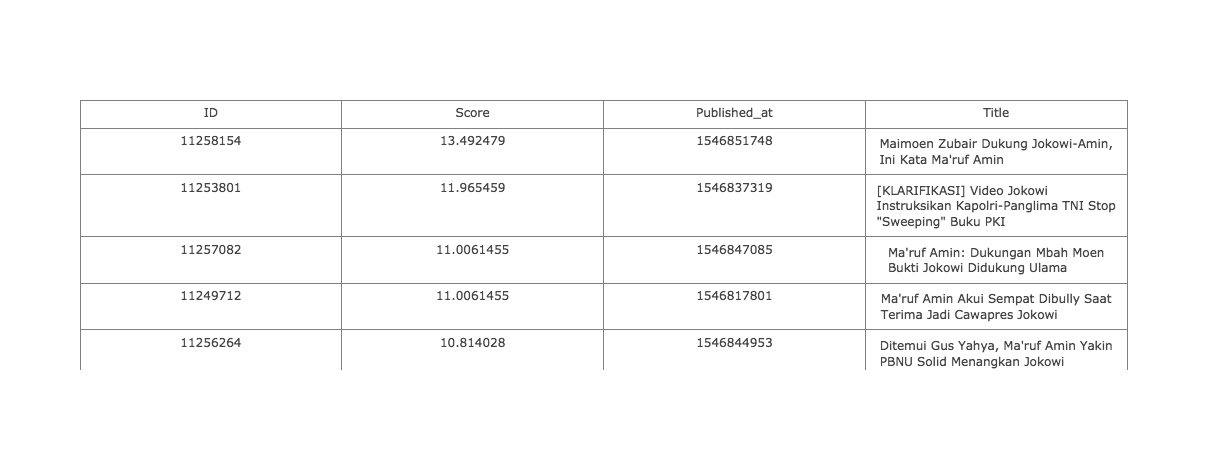

In [4]:
### SIMPLE QUERY SEARCH
query = '''
{
    "from": 0, 
    "size": 10,
    "query": {
        "bool": {
            "must": [
                {
                    "simple_query_string": {
                        "query": "jokowi +(pki | amin)",
                        "fields": [
                            "title"
                        ],
                        "default_operator": "or"
                    }
                }
            ]
        }
    },
    "sort": [
        "_score",
        {
            "published_at": "desc"
        }
    ]
}
'''
res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=res['hits']['total'], arg2=res['took']))

iplot(process_table_data(res['hits']['hits']))

150 documents found in 155ms


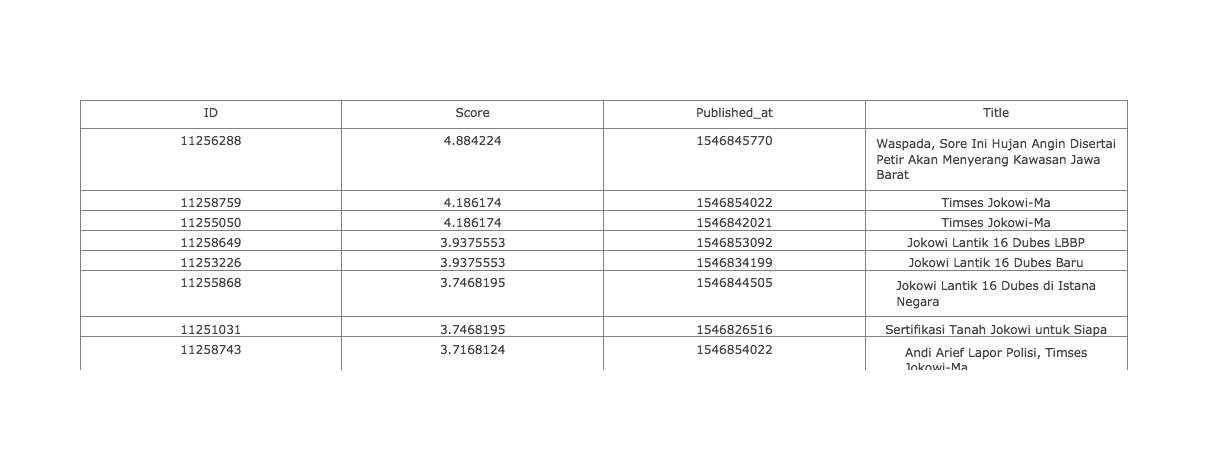

In [5]:
### FUZZY SEARCH
query = '''
{
    "from": 0, 
    "size": 10,
    "query": {
        "fuzzy": {
            "title": {
                "value": "jokawa",
                "fuzziness": 10,
                "max_expansions": 100
            }
        }
    },
    "sort": [
        "_score",
        {
            "published_at": "desc"
        }
    ]
}
'''
res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=res['hits']['total'], arg2=res['took']))

iplot(process_table_data(res['hits']['hits']))

136 documents found in 319ms


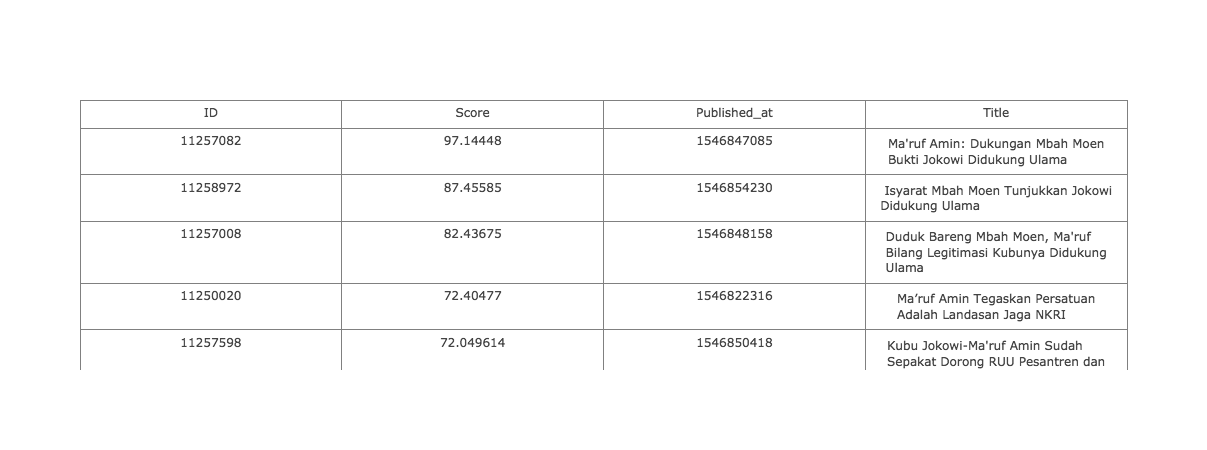

In [6]:
### MORE LIKE THIS QUERY
query = '''
{
    "from": 0, 
    "size": 10,
    "query": {
        "more_like_this": {
            "fields" : ["title","content"],
            "like" : [
            {
                "_index": "kurio_search",
                "_type": "article",
                "_id": 11258154
            }
            ]
        }
    },
    "sort": [
        "_score",
        {
            "published_at": "desc"
        }
    ]
}
'''

res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=res['hits']['total'], arg2=res['took']))

iplot(process_table_data(res['hits']['hits']))

375 documents found in 302ms


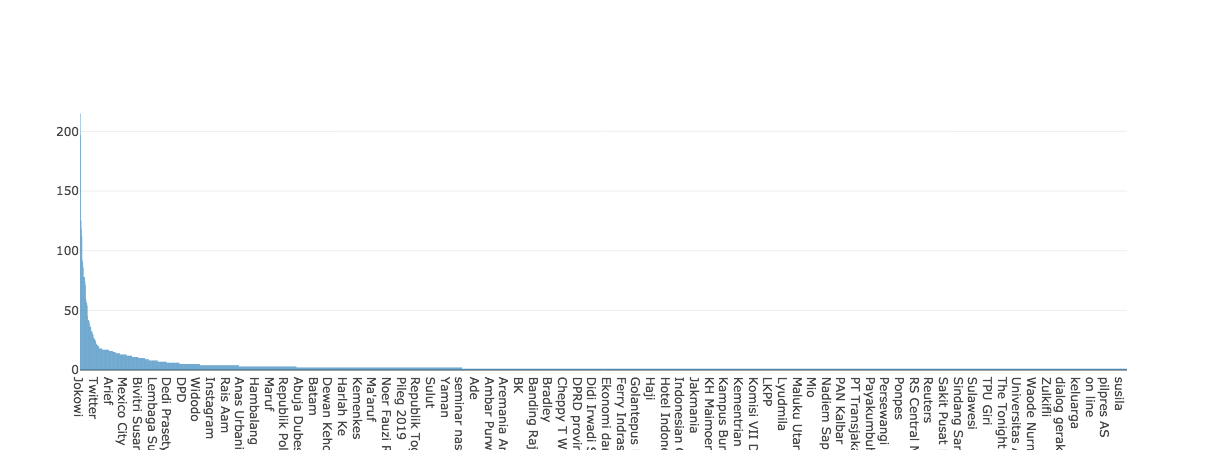

In [8]:
### AGGREGATION

query = '''
{
    "query": {
        "bool": {
            "must": [
                {
                    "simple_query_string": {
                        "query": "jokowi pilpres",
                        "fields": [
                            "title",
                            "content"
                        ],
                        "default_operator": "or"
                    }
                }
            ]
        }
    },
    "aggs": {
        "agg": {
            "terms": {
                "field": "entity_ids",
                "size": 1000000
            }
        }
    }
}
'''

res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=res['hits']['total'], arg2=res['took']))

iplot(process_chart_data(res))
    

10 documents found in 15ms


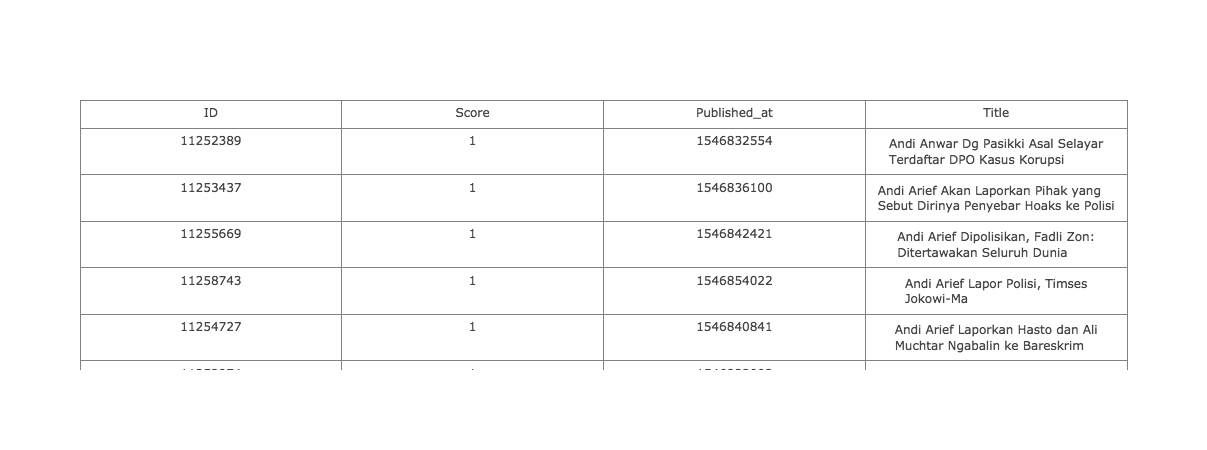

In [27]:
### SUGGESTER

query = '''
{
    "suggest": {
        "title-suggest" : {
            "text" : "and", 
            "completion" : { 
                "field" : "title.completion",
                "size" : 10,
                "skip_duplicates": true
            }
        }
    }
}
'''

res = es.search(index='kurio_search', doc_type='article', body=query)
print("{arg1} documents found in {arg2}ms".format(arg1=len(res['suggest']['title-suggest'][0]['options']), arg2=res['took']))
iplot(process_table_data(res['suggest']['title-suggest'][0]['options']))